In [13]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [111]:
VERSION = 74
CLOUD_SINGLE = False
MIXUP = False
DATA_SET = 3
NO_BLACK_LOSS = True
DATA_SMALL = False

if DATA_SET == 1:
    dataset_name = 'Densenet161'
    feat_sz = 2208
elif DATA_SET == 2:
    dataset_name = 'Densenet169'
    filename_add = '_3'
    filename_add2 = '_v3'
    feat_sz = 208
elif DATA_SET == 3:
    dataset_name = 'Densenet201'
    filename_add = '_3'
    filename_add2 = '_v3'
    feat_sz = 240
elif DATA_SET == 4:
    dataset_name = 'se_resnext101_32x4d'
    filename_add = ''
    filename_add2 = ''
    feat_sz = 256
elif DATA_SET == 5:
    dataset_name = 'Densenet161'
    filename_add = '_3'
    filename_add2 = '_v4'
    feat_sz = 552
else: assert False

In [96]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [97]:
all_black = '006d4432e'
all_black = '00bd6c59c'

if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 32
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 16

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [98]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [99]:
cols_le,cols_float,cols_bool = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_bool + cols_float

In [100]:
#meta_cols = ['ImagePositionPatient_1','pos_rel']

In [101]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'indexes_file.pkl'
        all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')
        
        assert len(ids_df.SeriesInstanceUID.unique()) == 19530
        
        trn_data = ids_df.loc[ids_df.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
        val_data = ids_df.loc[ids_df.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

        assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
            == len(train_md.SeriesInstanceUID.unique())

        assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
            >= len(train_md.PatientID.unique())

        pickle.dump((trn_data,val_data), open(PATH_WORK/'train.post.processed.1','wb'))
    else:
        trn_data,val_data = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [102]:
if DATA_SET == 1:
    if False:
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')

        assert len(test_md.SeriesInstanceUID.unique()) == 2214

        pickle.dump(test_md, open(PATH_WORK/'test.post.processed.1','wb'))
    else:
        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [103]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [112]:
if DATA_SET >= 2:
    if False:
        train_dedup = pd.read_csv(PATH_WORK/'yuval'/'train_dedup.csv')
        pids, folding = pickle.load(open(PATH_WORK/'yuval'/'PID_splits.pkl','rb'))

        assert len(pids) == 17079
        assert len(np.unique(pids)) == 17079

        for fol in folding:
            assert len(fol[0]) + len(fol[1]) == 17079

        assert len(folding[0][1]) + len(folding[1][1]) + len(folding[2][1]) == 17079

        assert len(train_dedup.PID.unique()) == 17079

        train_dedup['fold'] = np.nan

        for fold in range(3):
            train_dedup.loc[train_dedup.PID.isin(pids[folding[fold][1]]),'fold'] = fold

        assert train_dedup.fold.isnull().sum() == 0

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = train_dedup[['fold','PatientID']]
        ids_df.columns = ['fold','img_id']

        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')

        pickle.dump(ids_df, open(PATH_WORK/'features/{}{}/train/train.ids.df'.format(dataset_name, filename_add2),'wb'))

        #test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])
        
        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')
        
        assert len(test_md.SeriesInstanceUID.unique()) == 2214
        
        pickle.dump(test_md, open(PATH_WORK/'features/{}{}/test/test.ids.df'.format(dataset_name,filename_add2),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_{}{}_version_classifier_splits_type_features_train_tta_split_{}.pkl'\
                .format(dataset_name, filename_add, fold)
            feats = pickle.load(open(filename,'rb'))
            print('feats size', feats.shape)
            assert len(feats) == 4*len(ids_df)
            means = feats.mean(0,keepdim=True)
            stds = feats.std(0,keepdim=True)
            
            feats = feats - means
            feats = torch.where(stds > 0, feats/stds, feats)

            for i in range(4):
                feats_sub1 = feats[torch.BoolTensor(np.arange(len(feats))%4 == i)]
                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold != fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}{}/train/train.f{}.a{}'
                                             .format(dataset_name,filename_add2,fold,i),'wb'))

                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold == fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}{}/train/valid.f{}.a{}'
                                             .format(dataset_name,filename_add2,fold,i),'wb'))

                if i==0:
                    black_feats = feats_sub1[torch.BoolTensor(ids_df.img_id == all_black)].squeeze()
                    pickle.dump(black_feats, open(PATH_WORK/'features/{}{}/train/black.f{}'
                                                  .format(dataset_name,filename_add2,fold),'wb'))

            #filename = PATH_WORK/'yuval'/\
            #    'model_{}{}_version_classifier_splits_type_features_test_split_{}.pkl'\
            #    .format(dataset_name,filename_add,fold)
            filename = PATH_WORK/'yuval'/\
                'model_{}{}_version_classifier_splits_type_features_test_tta_split_{}.pkl'\
                .format(dataset_name,filename_add,fold)
            feats = pickle.load(open(filename,'rb'))
            
            feats = feats - means
            feats = torch.where(stds > 0, feats/stds, feats)
            
            for i in range(8):
                feats_sub = feats[torch.BoolTensor(np.arange(len(feats))%8 == i)]
                pickle.dump(feats_sub, open(PATH_WORK/'features/{}{}/test/test.f{}.a{}'
                                            .format(dataset_name,filename_add2,fold,i),'wb'))
                assert len(feats_sub) == len(test_md)
    else:
        ids_df = pickle.load(open(PATH_WORK/'features/{}{}/train/train.ids.df'.format(dataset_name,filename_add2),'rb'))
        test_md = pickle.load(open(PATH_WORK/'features/{}{}/test/test.ids.df'.format(dataset_name,filename_add2),'rb'))

In [105]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(test_md.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(test_md.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [25]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [26]:
#ff = pickle.load(open(PATH_WORK/'features/{}{}/{}/{}.f{}.a{}'\
#                .format(dataset_name,filename_add2,'train','train',0,0),'rb'))

In [27]:
#ff = pickle.load(open(PATH_WORK/'features/{}{}/{}/{}.f{}.a{}'\
#                .format(dataset_name,filename_add2,'test','test',0,0),'rb'))

In [28]:
#filename = PATH_WORK/'yuval'/\
#                'model_{}{}_version_classifier_splits_type_features_test_tta_split_{}.pkl'\
#                .format(dataset_name,filename_add,0)
#feats = pickle.load(open(filename,'rb'))

In [29]:
if DATA_SET == 1:
    path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
    black_feats = pickle.load(open(path,'rb'))[41]

In [30]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, mode='train', bs=None, dataset=DATA_SET, fold=0):
        
        super(RSNA_DataSet, self).__init__()
        
        if dataset == 1:
            md = metadata.copy()
            md = md.reset_index(drop=True)
        else:
            if mode == 'train':
                md = metadata.loc[metadata.fold != fold].copy().reset_index(drop=True)
            elif mode == 'valid':
                md = metadata.loc[metadata.fold == fold].copy().reset_index(drop=True)
            else:
                md = metadata.copy().reset_index(drop=True)
        
        series = np.sort(md.SeriesInstanceUID.unique())
        md = md.set_index('SeriesInstanceUID', drop=True)
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series, random.sample(list(series),samples_add)])
        self.metadata = md
        self.dataset = dataset
        self.fold = fold
        
        print('DataSet', dataset, mode, 'size', len(self.series), 'fold', fold)
        
        if self.dataset >= 2:
            path = PATH_WORK/'features/{}{}/train/black.f{}'.format(dataset_name, filename_add2, fold)
            self.black_feats = pickle.load(open(path,'rb')).squeeze()
        
        elif self.dataset == 1:
            self.black_feats = black_feats
    
    def setFeats(self, anum):
        def getAPath(an):
            return PATH_WORK/'features/{}{}/{}/{}.f{}.a{}'\
                .format(dataset_name,filename_add2,folder,self.mode,self.fold,an)
        
        if self.dataset == 1: return
        print('setFeats, augmentation', anum)
        self.anum = anum
        folder = 'test' if self.mode == 'test' else 'train'
        sz = len(self.metadata)
        if anum == -1:
            max_a = 8 if self.mode == 'test' else 4
            feats2 = torch.stack([pickle.load(open(getAPath(an),'rb')) for an in range(max_a)])
            feats = feats2[torch.randint(max_a,(sz,)), torch.arange(sz)].squeeze()
        else:
            feats = pickle.load(open(getAPath(anum),'rb'))
        
        self.feats = feats
        assert len(feats) == sz
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        #df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        df = self.metadata.loc[series_id].reset_index(drop=True)
        
        if self.dataset == 1:
            folder = 'test' if self.mode == 'test' else 'train'
            path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
            feats = pickle.load(open(path,'rb'))
            
            if feats.shape[0] > len(df.img_id.unique()):
                mask_dup = ~df.img_id.duplicated().values
                df = df.loc[mask_dup]
                feats = feats[torch.BoolTensor(mask_dup)]
            
            assert feats.shape[0] == len(df)
        elif self.dataset >= 2:
            feats = self.feats[torch.BoolTensor(self.metadata.index.values == series_id)]
        else: assert False
        
        order = np.argsort(df.pos_idx1.values)
        df = df.sort_values(['pos_idx1'])
        feats = feats[torch.LongTensor(order)]
        
        non_black = torch.ones(len(feats))
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        feats_le = torch.LongTensor(df[cols_le].values)
        
        target = torch.Tensor(df[all_ich].values)
        
        #PAD = 4+9+1
        PAD = 8
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        top_pad = PAD + offset
        if top_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(top_pad,1), feats], dim=0)
            feats_le = torch.cat([torch.LongTensor(df.head(1)[cols_le].values).squeeze().repeat(top_pad,1), feats_le])
            if offset > 0:
                non_black = torch.cat([0.01 + torch.zeros(offset), non_black])
                target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        bot_pad = 60 - len(df) - offset + PAD
        if bot_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(bot_pad,1)], dim=0)
            feats_le = torch.cat([feats_le, torch.LongTensor(df.tail(1)[cols_le].values).squeeze().repeat(bot_pad,1)])
            if (60 - len(df) - offset) > 0:
                non_black = torch.cat([non_black, 0.01 + torch.zeros(60 - len(df) - offset)])
                target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats_le.shape[0] == (60 + 2*PAD)
        assert feats.shape[0] == (60 + 2*PAD)
        assert target.shape[0] == 60
        
        #feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, feats_le, target, non_black
        else:
            return feats, feats_le, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [31]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [32]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    
    def forward(self, input, target, batch_weights = None):
        loss = (torch.log(1+torch.exp(input)) - target*input)*self.weight
        if batch_weights is not None:
            loss = batch_weights*loss
        return loss.mean()

In [33]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [34]:
def noop(x): return x
act_fun = nn.ReLU(inplace=True)

def conv_layer(ni, nf, ks=3, act=True):
    bn = nn.BatchNorm1d(nf)
    layers = [nn.Conv1d(ni, nf, ks), bn]
    if act: layers.append(act_fun)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        layers  = [conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 5, act=False)]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if (ni == nh) else conv_layer(ni, nh, 1, act=False)
    
    def forward(self, x): return act_fun(self.convs(x) + self.idconv(x[:,:,2:-2]))

In [35]:
class ResNetModel(nn.Module):
    def __init__(self, n_cont:int, feat_sz=2208):
        super().__init__()
        
        self.le_sz = 9
        le_in_sizes = np.array([5,5,7,4,4,11,4,6,3])
        le_out_sizes = np.array([3,3,4,2,2,6,2,4,2])
        le_out_sz = le_out_sizes.sum()
        self.embeddings = nn.ModuleList([embedding(le_in_sizes[i], le_out_sizes[i]) for i in range(self.le_sz)])

        self.feat_sz = feat_sz
        
        self.n_cont = n_cont
        
        self.conv2D = nn.Conv2d(1,64,(feat_sz + n_cont + le_out_sz,1))
        self.bn1 = nn.BatchNorm1d(64)
        
        self.res1 = ResBlock(64,64)
        self.res2 = ResBlock(64,64)
        self.res3 = ResBlock(64,64)
        self.res4 = ResBlock(64,64)
        
        self.conv1D = nn.Conv1d(128,6,1)
    
    def forward(self, x, x_le, x_le_mix = None, lambd = None) -> torch.Tensor:
        x_le = [e(x_le[:,:,i]) for i,e in enumerate(self.embeddings)]
        x_le = torch.cat(x_le, 2)
        
        x = torch.cat([x, x_le], 2)
        x = x.transpose(1,2)
        
        #x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        
        x = self.conv2D(x).squeeze()
        x = self.bn1(x)
        x = act_fun(x)
        
        x2 = self.res1(x)
        x2 = self.res2(x2)
        x2 = self.res3(x2)
        x2 = self.res4(x2)
        
        x = torch.cat([x[:,:,8:-8], x2], 1)
        x = self.conv1D(x)
        x = x.transpose(1,2)
        
        return x

In [36]:
def trunc_normal_(x, mean:float=0., std:float=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [37]:
def embedding(ni:int,nf:int) -> nn.Module:
    "Create an embedding layer."
    emb = nn.Embedding(ni, nf)
    # See https://arxiv.org/abs/1711.09160
    with torch.no_grad(): trunc_normal_(emb.weight, std=0.01)
    return emb

In [38]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        self.le_sz = 9
        le_in_sizes = np.array([5,5,7,4,4,11,4,6,3])
        le_out_sizes = np.array([3,3,4,2,2,6,2,4,2])
        le_out_sz = le_out_sizes.sum()
        self.embeddings = nn.ModuleList([embedding(le_in_sizes[i], le_out_sizes[i]) for i in range(self.le_sz)])
        #self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont + le_out_sz)
        self.n_cont = n_cont
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        
        scale = 4
        
        self.conv2D_1 = nn.Conv2d(1,16*scale,(feat_sz + n_cont + le_out_sz,1))
        self.conv2D_2 = nn.Conv2d(1,16*scale,(feat_sz + n_cont + le_out_sz,5))
        self.bn_cont1 = nn.BatchNorm1d(32*scale)
        self.conv1D_1 = nn.Conv1d(32*scale,16*scale,3)
        self.conv1D_3 = nn.Conv1d(32*scale,16*scale,5,dilation=5)
        self.conv1D_2 = nn.Conv1d(32*scale,6,3)
        self.bn_cont2 = nn.BatchNorm1d(32*scale)
        self.bn_cont3 = nn.BatchNorm1d(6)

        self.conv1D_4 = nn.Conv1d(32*scale,32*scale,3)
        self.bn_cont4 = nn.BatchNorm1d(32*scale)

    def forward(self, x, x_le, x_le_mix = None, lambd = None) -> torch.Tensor:
        x_le = [e(x_le[:,:,i]) for i,e in enumerate(self.embeddings)]
        x_le = torch.cat(x_le, 2)
        
        if MIXUP and x_le_mix is not None:
            x_le_mix = [e(x_le_mix[:,:,i]) for i,e in enumerate(self.embeddings)]
            x_le_mix = torch.cat(x_le_mix, 2)
            x_le = lambd * x_le + (1-lambd) * x_le_mix
        
        #assert torch.isnan(x_le).any().cpu() == False
        x = torch.cat([x, x_le], 2)
        x = x.transpose(1,2)
        
        #x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        x = self.fc_drop(x)
        x = torch.cat([self.conv2D_1(x[:,:,:,2:(-2)]).squeeze(), 
                       self.conv2D_2(x).squeeze()], dim=1)
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        
        x = torch.cat([self.conv1D_1(x[:,:,9:(-9)]),
                       self.conv1D_3(x)], dim=1)
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        
        x = self.conv1D_4(x)
        x = self.relu(x)
        x = self.bn_cont4(x)
        
        x = self.conv1D_2(x)
        x = x.transpose(1,2)
        
        return x

# Training

In [39]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    mixup_collected = False
    x_le_mix = None
    lambd = None
    for i, (x, x_le, y, non_black) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
            y = y.to(device)
            non_black = non_black.to(device)
        
        if MIXUP:
            if mixup_collected:
                lambd = np.random.beta(0.4, 0.4, y.size(0))
                lambd = torch.Tensor(lambd).to(device)[:,None,None]
                #shuffle = torch.randperm(y.size(0)).to(device)
                x = lambd * x + (1-lambd) * x_mix #x[shuffle]
                #x_le = lambd * x_le + (1-lambd) * x_le_mix #x[shuffle]
                mixup_collected = False
            else:
                x_mix = x
                x_le_mix = x_le
                y_mix = y
                mixup_collected = True
                continue
        
        optimizer.zero_grad()
        output = model(x, x_le, x_le_mix, lambd)
        
        if MIXUP:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, lambd*non_black[:,:,None]) \
                     + criterion(output, y_mix, (1-lambd)*non_black[:,:,None])
            else:
                loss = criterion(output, y, lambd) + criterion(output, y_mix, 1-lambd)
            del x_mix, y_mix
        else:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, non_black[:,:,None])
            else:
                loss = criterion(output, y)
        
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x, x_le
    
    return tloss, tloss_count

In [40]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = model(x, x_le)
        assert torch.isnan(output).any().cpu() == False
        output = torch.sigmoid(output)
        assert torch.isnan(output).any().cpu() == False
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, x_le, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [41]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = torch.sigmoid(model(x, x_le))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [42]:
def train_one(weight=None, load_model=True, epochs=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    if DATA_SET == 1:
        trn_ds = RSNA_DataSet(trn_data, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(val_data, mode='valid', bs=bs, fold=fold)
    elif DATA_SET >= 2:
        trn_ds = RSNA_DataSet(ids_df, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    else: assert False
    val_ds.setFeats(0)
    
    loader = D.DataLoader(trn_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                          shuffle=True, drop_last=True)
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    #model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
        
    loc_data = val_ds.metadata.copy()

    if DATA_SMALL:
        #val_sz = int(0.01*len(loc_data.index.unique()))
        val_sz = len(val_ds)
        val_series = val_ds.series[:val_sz]
        loc_data = loc_data.loc[loc_data.index.isin(val_series)]
    
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        
        #trn_ds.setFeats((i-1) % 4)
        trn_ds.setFeats(-1)
        
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True, fold=fold)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        #val_results = np.zeros((len(loc_data),6))
        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            #mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + cnt) <= 60
            #val_results[mask] = predictions[k,offsets[k]:(offsets[k] + cnt)]
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])
        
        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-7, labels=[0,1])\
               for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, epoch {}, fold {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}, lr: {}'
              .format(VERSION, i, fold, tr_ll, ll, cor, auc, learning_rate))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(fold,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    print('total running time', time.time() - st0)
    
    return model, predictions

In [43]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [44]:
# rerunning
# ver 78, epoch 25, fold 0, train ll: 0.0283, val ll: 0.0633, cor: 0.8433, auc: 0.9882, lr: 5e-06
# ver 78, epoch 25, fold 1, train ll: 0.0287, val ll: 0.0624, cor: 0.8414, auc: 0.9881, lr: 5e-06


# MIXUP
# ver 76, epoch 55, fold 0, train ll: 0.0461, val ll: 0.0656, cor: 0.8393, auc: 0.9868, lr: 5e-06
#--- dataset 4


# ver 75, epoch 25, fold 0, train ll: 0.0284, val ll: 0.0634, cor: 0.8430, auc: 0.9883, lr: 5e-06
# ver 75, epoch 25, fold 1, train ll: 0.0291, val ll: 0.0622, cor: 0.8418, auc: 0.9881, lr: 5e-06
# ver 75, epoch 25, fold 2, train ll: 0.0287, val ll: 0.0600, cor: 0.8442, auc: 0.9896, lr: 5e-06
#--- dataset 4

# ver 74, epoch 25, fold 0, train ll: 0.0285, val ll: 0.0637, cor: 0.8425, auc: 0.9880, lr: 5e-06
# ver 74, epoch 25, fold 1, train ll: 0.0285, val ll: 0.0630, cor: 0.8404, auc: 0.9879, lr: 5e-06
# ver 74, epoch 25, fold 2, train ll: 0.0287, val ll: 0.0605, cor: 0.8430, auc: 0.9893, lr: 5e-06
#--- dataset 3

# ver 73, epoch 25, fold 0, train ll: 0.0282, val ll: 0.0637, cor: 0.8431, auc: 0.9879, lr: 5e-06
# ver 73, epoch 25, fold 1, train ll: 0.0291, val ll: 0.0631, cor: 0.8396, auc: 0.9878, lr: 5e-06
# ver 73, epoch 25, fold 2, train ll: 0.0288, val ll: 0.0607, cor: 0.8431, auc: 0.9891, lr: 5e-06
#--- dataset 2

# ResNet, concat
# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
# ver 72, epoch 25, fold 0, train ll: 0.0280, val ll: 0.0639, cor: 0.8426, auc: 0.9878, lr: 5e-06
# ver 72, epoch 25, fold 1, train ll: 0.0281, val ll: 0.0634, cor: 0.8381, auc: 0.9879, lr: 5e-06
# ver 72, epoch 25, fold 2, train ll: 0.0284, val ll: 0.0608, cor: 0.8429, auc: 0.9890, lr: 5e-06


# ResNet, PAD=8
# ver 71, epoch 20, fold 0, train ll: 0.0302, val ll: 0.0647, cor: 0.8414, auc: 0.9870, lr: 5e-06

# TabularModel, feats norm, scale = 4
# ver 70, epoch 20, fold 0, train ll: 0.0295, val ll: 0.0654, cor: 0.8417, auc: 0.9867, lr: 5e-06
# TabularModel, feats norm, scale = 8
# ver 69, epoch 20, fold 0, train ll: 0.0287, val ll: 0.0651, cor: 0.8417, auc: 0.9868, lr: 5e-06

# ResNet, feats norm
# 3x1e-3, 7x2e-4, 7x2e-5, 3x5e-6
# ver 68, epoch 20, fold 0, train ll: 0.0307, val ll: 0.0648, cor: 0.8410, auc: 0.9871, lr: 5e-06

# ResNet try2, PAD=3
# ver 67, epoch 29, fold 0, train ll: 0.0360, val ll: 0.0711, cor: 0.8217, auc: 0.9842, lr: 5e-06
# ver 67, epoch 36, fold 0, train ll: 0.0345, val ll: 0.0701, cor: 0.8279, auc: 0.9838, lr: 2e-05

# scale=2, reduced by 2
# 3x1e-3, 7x2e-4, 7x2e-5, 3x5e-6
# ver 66, epoch 20, fold 1, train ll: 0.0327, val ll: 0.0659, cor: 0.8372, auc: 0.9864, lr: 5e-06
# ver 66, epoch 20, fold 2, train ll: 0.0330, val ll: 0.0635, cor: 0.8415, auc: 0.9879, lr: 5e-06

# 3x1e-3, 7x2e-4, 7x2e-5, 3x5e-6
# ver 64, epoch 17, fold 0, train ll: 0.0298, val ll: 0.0647, cor: 0.8431, auc: 0.9871, lr: 2e-05
# ver 64, epoch 20, fold 0, train ll: 0.0297, val ll: 0.0646, cor: 0.8433, auc: 0.9869, lr: 5e-06
# ver 65, epoch 17, fold 1, train ll: 0.0303, val ll: 0.0648, cor: 0.8379, auc: 0.9870, lr: 2e-05
# ver 65, epoch 20, fold 1, train ll: 0.0301, val ll: 0.0647, cor: 0.8375, auc: 0.9870, lr: 5e-06
# ver 65, epoch 17, fold 2, train ll: 0.0303, val ll: 0.0625, cor: 0.8417, auc: 0.9881, lr: 2e-05
# ver 65, epoch 20, fold 2, train ll: 0.0303, val ll: 0.0625, cor: 0.8416, auc: 0.9882, lr: 5e-06

#--- dataset 5

# Mixup
# 5x5e-6 more
# ver 61, epoch 49, fold 1, train ll: 0.0471, val ll: 0.0639, cor: 0.8392, auc: 0.9867, lr: 5e-06
# ver 61, epoch 49, fold 2, train ll: 0.0466, val ll: 0.0618, cor: 0.8408, auc: 0.9887, lr: 5e-06
# 6x1e-3, 14x2e-4, 24x2e-5
# ver 63, epoch 45, fold 0, train ll: 0.0467, val ll: 0.0641, cor: 0.8426, auc: 0.9872, lr: 2e-05
# ver 61, epoch 44, fold 1, train ll: 0.0474, val ll: 0.0642, cor: 0.8390, auc: 0.9867, lr: 2e-05
# ver 61, epoch 44, fold 2, train ll: 0.0464, val ll: 0.0619, cor: 0.8405, auc: 0.9888, lr: 2e-05

# 5x2e-5, 5x5e-6 more
# ver 61, epoch 32, fold 0, train ll: 0.0282, val ll: 0.0647, cor: 0.8418, auc: 0.9876, lr: 5e-06
# 3x1e-3, 7x2e-4, 2x2e-5
# ver 61, epoch 20, fold 0, train ll: 0.0292, val ll: 0.0650, cor: 0.8418, auc: 0.9876, lr: 2e-05

# ll eps change, black 0.1
# 10x2e-4, 10x2e-5

# ver 53, epoch 28, fold 0, train ll: 0.0290, val ll: 0.0647, cor: 0.8424, auc: 0.9869, lr: 2e-05
# ver 53, epoch 28, fold 1, train ll: 0.0293, val ll: 0.0635, cor: 0.8408, auc: 0.9871, lr: 2e-05
# ver 53, epoch 28, fold 2, train ll: 0.0291, val ll: 0.0616, cor: 0.8422, auc: 0.9890, lr: 2e-05

# ver 53, epoch 21, fold 0, train ll: 0.0297, val ll: 0.0652, cor: 0.8415, auc: 0.9857, lr: 0.0002
# ver 53, epoch 21, fold 1, train ll: 0.0301, val ll: 0.0643, cor: 0.8394, auc: 0.9864, lr: 0.0002
# ver 53, epoch 21, fold 2, train ll: 0.0296, val ll: 0.0621, cor: 0.8417, auc: 0.9888, lr: 0.0002

#--- dataset 4

# 7x0.00002 more
# ver 52, epoch 28, fold 0, train ll: 0.0297, val ll: 0.0646, cor: 0.8422, auc: 0.9868, lr: 2e-05
# ver 52, epoch 28, fold 1, train ll: 0.0297, val ll: 0.0638, cor: 0.8395, auc: 0.9871, lr: 2e-05
# ver 52, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0622, cor: 0.8407, auc: 0.9883, lr: 2e-05
# 7x0.002, 7x0.001, 7x0.0002
# ver 52, epoch 21, fold 0, train ll: 0.0302, val ll: 0.0653, cor: 0.8409, auc: 0.9864, lr: 0.0002
# ver 52, epoch 21, fold 1, train ll: 0.0305, val ll: 0.0648, cor: 0.8379, auc: 0.9862, lr: 0.0002
# ver 52, epoch 21, fold 2, train ll: 0.0305, val ll: 0.0622, cor: 0.8400, auc: 0.9883, lr: 0.0002

#--- dataset 3

# 7x0.00002 more
# ver 51, epoch 28, fold 0, train ll: 0.0293, val ll: 0.0649, cor: 0.8417, auc: 0.9868, lr: 2e-05
# ver 51, epoch 32, fold 1, train ll: 0.0298, val ll: 0.0646, cor: 0.8379, auc: 0.9868, lr: 2e-05
# ver 51, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0621, cor: 0.8411, auc: 0.9882, lr: 2e-05

# 7x0.002, 7x0.001, 7x0.0002
# new metadata
# ver 51, epoch 21, fold 0, train ll: 0.0299, val ll: 0.0651, cor: 0.8411, auc: 0.9869, lr: 0.0002
# ver 51, epoch 21, fold 1, train ll: 0.0302, val ll: 0.0647, cor: 0.8374, auc: 0.9874, lr: 0.0002
# ver 51, epoch 21, fold 2, train ll: 0.0302, val ll: 0.0625, cor: 0.8400, auc: 0.9881, lr: 0.0002

In [45]:
# one-cycle
# copy latest model to GS code
# improve black image meta data
# freeze bias approach?
# pseudo-labelling?
# try GCP fast guide connecting
# can it happen that any smaller than max of others
# why black feats are predicted all ones
# on test, do I have horns?
# normalize input feats
# what is the score without meta

In [50]:
DATA_SMALL = False
weight_decay = 1e-3
f = 0
stg = time.time()
learning_rate = 1e-3
model, predictions = train_one(epochs=5, bs=bs, fold=f)
learning_rate = 2e-4
model, predictions = train_one(epochs=10, bs=bs, fold=f)
learning_rate = 2e-5
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 5e-6
model, predictions = train_one(epochs=3, bs=bs, fold=f)
print('total time', time.time() - stg)

completed epochs: 0 starting now: 5
DataSet 4 train size 13042 fold 0
adding dummy serieses 168
DataSet 4 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.589 time per batch: 1.647
Batch 8 device: xla:1 time passed: 10.876 time per batch: 1.359
Batch 12 device: xla:1 time passed: 15.621 time per batch: 1.302
Batch 16 device: xla:1 time passed: 20.576 time per batch: 1.286
Batch 20 device: xla:1 time passed: 25.472 time per batch: 1.274
Batch 24 device: xla:1 time passed: 30.023 time per batch: 1.251
Batch 28 device: xla:1 time passed: 34.797 time per batch: 1.243
Batch 32 device: xla:1 time passed: 39.682 time per batch: 1.240
Batch 36 device: xla:1 time passed: 44.331 time per batch: 1.231
Batch 40 device: xla:1 time passed: 49.282 time per batch: 1.232
Batch 44 device: xla:1 time passed: 54.037 time per batch: 1.228
Batch 48 device: xla:1 t

Batch 4 device: xla:1 time passed: 7.615 time per batch: 1.904
Batch 8 device: xla:1 time passed: 11.945 time per batch: 1.493
Batch 12 device: xla:1 time passed: 16.751 time per batch: 1.396
Batch 16 device: xla:1 time passed: 21.592 time per batch: 1.350
Batch 20 device: xla:1 time passed: 26.360 time per batch: 1.318
Batch 24 device: xla:1 time passed: 31.100 time per batch: 1.296
Batch 28 device: xla:1 time passed: 35.824 time per batch: 1.279
Batch 32 device: xla:1 time passed: 40.525 time per batch: 1.266
Batch 36 device: xla:1 time passed: 45.406 time per batch: 1.261
Batch 40 device: xla:1 time passed: 49.999 time per batch: 1.250
Batch 44 device: xla:1 time passed: 54.234 time per batch: 1.233
Batch 48 device: xla:1 time passed: 58.422 time per batch: 1.217
Batch 4 device: xla:1 time passed: 4.658 time per batch: 1.164
Batch 8 device: xla:1 time passed: 6.844 time per batch: 0.855
Batch 12 device: xla:1 time passed: 9.493 time per batch: 0.791
Batch 16 device: xla:1 time passe

Batch 36 device: xla:1 time passed: 45.071 time per batch: 1.252
Batch 40 device: xla:1 time passed: 49.961 time per batch: 1.249
Batch 44 device: xla:1 time passed: 54.772 time per batch: 1.245
Batch 48 device: xla:1 time passed: 59.319 time per batch: 1.236
Batch 4 device: xla:1 time passed: 5.166 time per batch: 1.291
Batch 8 device: xla:1 time passed: 7.350 time per batch: 0.919
Batch 12 device: xla:1 time passed: 10.116 time per batch: 0.843
Batch 16 device: xla:1 time passed: 12.611 time per batch: 0.788
Batch 20 device: xla:1 time passed: 15.182 time per batch: 0.759
Batch 24 device: xla:1 time passed: 17.809 time per batch: 0.742
ver 78, epoch 13, fold 0, train ll: 0.0299, val ll: 0.0638, cor: 0.8420, auc: 0.9876, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.466 time per batch: 1.616
Batch 8 device: xla:1 time passed: 10.386 time per batch: 1.298
Batch 12 device: xla:1 time passed: 14.661 time per batch: 1.222
Batch 16 device: xla:1 time passed: 19.

Batch 4 device: xla:1 time passed: 4.397 time per batch: 1.099
Batch 8 device: xla:1 time passed: 6.413 time per batch: 0.802
Batch 12 device: xla:1 time passed: 8.695 time per batch: 0.725
Batch 16 device: xla:1 time passed: 11.043 time per batch: 0.690
Batch 20 device: xla:1 time passed: 13.315 time per batch: 0.666
Batch 24 device: xla:1 time passed: 15.615 time per batch: 0.651
ver 78, epoch 19, fold 0, train ll: 0.0286, val ll: 0.0631, cor: 0.8432, auc: 0.9883, lr: 2e-05
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.565 time per batch: 1.891
Batch 8 device: xla:1 time passed: 12.027 time per batch: 1.503
Batch 12 device: xla:1 time passed: 16.819 time per batch: 1.402
Batch 16 device: xla:1 time passed: 21.392 time per batch: 1.337
Batch 20 device: xla:1 time passed: 25.659 time per batch: 1.283
Batch 24 device: xla:1 time passed: 29.686 time per batch: 1.237
Batch 28 device: xla:1 time passed: 33.846 time per batch: 1.209
Batch 32 device: xla:1 time passed: 38.45

Batch 20 device: xla:1 time passed: 13.536 time per batch: 0.677
Batch 24 device: xla:1 time passed: 15.850 time per batch: 0.660
ver 78, epoch 25, fold 0, train ll: 0.0283, val ll: 0.0633, cor: 0.8433, auc: 0.9882, lr: 5e-06
total running time 256.9564299583435
total time 2148.333319425583


In [51]:
DATA_SMALL = False
weight_decay = 1e-3
f = 1
stg = time.time()
learning_rate = 1e-3
model, predictions = train_one(epochs=5, bs=bs, fold=f)
learning_rate = 2e-4
model, predictions = train_one(epochs=10, bs=bs, fold=f)
learning_rate = 2e-5
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 5e-6
model, predictions = train_one(epochs=3, bs=bs, fold=f)
print('total time', time.time() - stg)

completed epochs: 0 starting now: 5
DataSet 4 train size 12982 fold 1
adding dummy serieses 108
DataSet 4 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.609 time per batch: 1.902
Batch 8 device: xla:1 time passed: 12.007 time per batch: 1.501
Batch 12 device: xla:1 time passed: 16.786 time per batch: 1.399
Batch 16 device: xla:1 time passed: 20.874 time per batch: 1.305
Batch 20 device: xla:1 time passed: 25.025 time per batch: 1.251
Batch 24 device: xla:1 time passed: 29.211 time per batch: 1.217
Batch 28 device: xla:1 time passed: 33.671 time per batch: 1.203
Batch 32 device: xla:1 time passed: 38.294 time per batch: 1.197
Batch 36 device: xla:1 time passed: 43.041 time per batch: 1.196
Batch 40 device: xla:1 time passed: 47.979 time per batch: 1.199
Batch 44 device: xla:1 time passed: 52.653 time per batch: 1.197
Batch 48 device: xla:1 t

Batch 4 device: xla:1 time passed: 7.596 time per batch: 1.899
Batch 8 device: xla:1 time passed: 12.012 time per batch: 1.502
Batch 12 device: xla:1 time passed: 16.717 time per batch: 1.393
Batch 16 device: xla:1 time passed: 21.593 time per batch: 1.350
Batch 20 device: xla:1 time passed: 26.318 time per batch: 1.316
Batch 24 device: xla:1 time passed: 31.053 time per batch: 1.294
Batch 28 device: xla:1 time passed: 35.808 time per batch: 1.279
Batch 32 device: xla:1 time passed: 40.551 time per batch: 1.267
Batch 36 device: xla:1 time passed: 45.375 time per batch: 1.260
Batch 40 device: xla:1 time passed: 50.127 time per batch: 1.253
Batch 44 device: xla:1 time passed: 54.431 time per batch: 1.237
Batch 48 device: xla:1 time passed: 58.685 time per batch: 1.223
Batch 4 device: xla:1 time passed: 4.546 time per batch: 1.136
Batch 8 device: xla:1 time passed: 6.841 time per batch: 0.855
Batch 12 device: xla:1 time passed: 9.547 time per batch: 0.796
Batch 16 device: xla:1 time passe

Batch 36 device: xla:1 time passed: 45.325 time per batch: 1.259
Batch 40 device: xla:1 time passed: 50.102 time per batch: 1.253
Batch 44 device: xla:1 time passed: 54.888 time per batch: 1.247
Batch 48 device: xla:1 time passed: 59.621 time per batch: 1.242
Batch 4 device: xla:1 time passed: 5.137 time per batch: 1.284
Batch 8 device: xla:1 time passed: 7.306 time per batch: 0.913
Batch 12 device: xla:1 time passed: 9.996 time per batch: 0.833
Batch 16 device: xla:1 time passed: 12.652 time per batch: 0.791
Batch 20 device: xla:1 time passed: 15.251 time per batch: 0.763
Batch 24 device: xla:1 time passed: 17.915 time per batch: 0.746
ver 78, epoch 13, fold 1, train ll: 0.0305, val ll: 0.0645, cor: 0.8376, auc: 0.9883, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.676 time per batch: 1.669
Batch 8 device: xla:1 time passed: 10.494 time per batch: 1.312
Batch 12 device: xla:1 time passed: 14.667 time per batch: 1.222
Batch 16 device: xla:1 time passed: 19.4

Batch 4 device: xla:1 time passed: 5.136 time per batch: 1.284
Batch 8 device: xla:1 time passed: 7.404 time per batch: 0.925
Batch 12 device: xla:1 time passed: 10.020 time per batch: 0.835
Batch 16 device: xla:1 time passed: 12.652 time per batch: 0.791
Batch 20 device: xla:1 time passed: 15.254 time per batch: 0.763
Batch 24 device: xla:1 time passed: 17.941 time per batch: 0.748
ver 78, epoch 19, fold 1, train ll: 0.0290, val ll: 0.0625, cor: 0.8410, auc: 0.9880, lr: 2e-05
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 6.604 time per batch: 1.651
Batch 8 device: xla:1 time passed: 10.263 time per batch: 1.283
Batch 12 device: xla:1 time passed: 14.481 time per batch: 1.207
Batch 16 device: xla:1 time passed: 19.267 time per batch: 1.204
Batch 20 device: xla:1 time passed: 23.965 time per batch: 1.198
Batch 24 device: xla:1 time passed: 28.716 time per batch: 1.197
Batch 28 device: xla:1 time passed: 33.552 time per batch: 1.198
Batch 32 device: xla:1 time passed: 38.3

Batch 20 device: xla:1 time passed: 13.504 time per batch: 0.675
Batch 24 device: xla:1 time passed: 16.201 time per batch: 0.675
ver 78, epoch 25, fold 1, train ll: 0.0287, val ll: 0.0624, cor: 0.8414, auc: 0.9881, lr: 5e-06
total running time 262.2719442844391
total time 2156.3935782909393


In [52]:
DATA_SMALL = False
weight_decay = 1e-3
f = 2
stg = time.time()
learning_rate = 1e-3
model, predictions = train_one(epochs=5, bs=bs, fold=f)
learning_rate = 2e-4
model, predictions = train_one(epochs=10, bs=bs, fold=f)
learning_rate = 2e-5
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 5e-6
model, predictions = train_one(epochs=3, bs=bs, fold=f)
print('total time', time.time() - stg)

completed epochs: 0 starting now: 5
DataSet 4 train size 13036 fold 2
adding dummy serieses 162
DataSet 4 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.753 time per batch: 1.938
Batch 8 device: xla:1 time passed: 11.692 time per batch: 1.462
Batch 12 device: xla:1 time passed: 15.804 time per batch: 1.317
Batch 16 device: xla:1 time passed: 20.035 time per batch: 1.252
Batch 20 device: xla:1 time passed: 24.075 time per batch: 1.204
Batch 24 device: xla:1 time passed: 28.866 time per batch: 1.203
Batch 28 device: xla:1 time passed: 33.733 time per batch: 1.205
Batch 32 device: xla:1 time passed: 38.384 time per batch: 1.199
Batch 36 device: xla:1 time passed: 43.273 time per batch: 1.202
Batch 40 device: xla:1 time passed: 48.168 time per batch: 1.204
Batch 44 device: xla:1 time passed: 53.177 time per batch: 1.209
Batch 48 device: xla:1 t

Batch 4 device: xla:1 time passed: 7.624 time per batch: 1.906
Batch 8 device: xla:1 time passed: 11.997 time per batch: 1.500
Batch 12 device: xla:1 time passed: 16.856 time per batch: 1.405
Batch 16 device: xla:1 time passed: 21.707 time per batch: 1.357
Batch 20 device: xla:1 time passed: 26.459 time per batch: 1.323
Batch 24 device: xla:1 time passed: 31.324 time per batch: 1.305
Batch 28 device: xla:1 time passed: 36.039 time per batch: 1.287
Batch 32 device: xla:1 time passed: 40.821 time per batch: 1.276
Batch 36 device: xla:1 time passed: 45.438 time per batch: 1.262
Batch 40 device: xla:1 time passed: 50.363 time per batch: 1.259
Batch 44 device: xla:1 time passed: 54.770 time per batch: 1.245
Batch 48 device: xla:1 time passed: 58.924 time per batch: 1.228
Batch 4 device: xla:1 time passed: 4.586 time per batch: 1.146
Batch 8 device: xla:1 time passed: 6.821 time per batch: 0.853
Batch 12 device: xla:1 time passed: 9.577 time per batch: 0.798
Batch 16 device: xla:1 time passe

Batch 36 device: xla:1 time passed: 46.017 time per batch: 1.278
Batch 40 device: xla:1 time passed: 50.841 time per batch: 1.271
Batch 44 device: xla:1 time passed: 55.613 time per batch: 1.264
Batch 48 device: xla:1 time passed: 60.352 time per batch: 1.257
Batch 4 device: xla:1 time passed: 5.088 time per batch: 1.272
Batch 8 device: xla:1 time passed: 7.324 time per batch: 0.916
Batch 12 device: xla:1 time passed: 9.962 time per batch: 0.830
Batch 16 device: xla:1 time passed: 12.490 time per batch: 0.781
Batch 20 device: xla:1 time passed: 14.772 time per batch: 0.739
Batch 24 device: xla:1 time passed: 17.072 time per batch: 0.711
ver 78, epoch 13, fold 2, train ll: 0.0333, val ll: 0.0628, cor: 0.8361, auc: 0.9879, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.495 time per batch: 1.874
Batch 8 device: xla:1 time passed: 11.771 time per batch: 1.471
Batch 12 device: xla:1 time passed: 16.464 time per batch: 1.372
Batch 16 device: xla:1 time passed: 21.2

Batch 4 device: xla:1 time passed: 4.478 time per batch: 1.119
Batch 8 device: xla:1 time passed: 6.523 time per batch: 0.815
Batch 12 device: xla:1 time passed: 8.736 time per batch: 0.728
Batch 16 device: xla:1 time passed: 11.142 time per batch: 0.696
Batch 20 device: xla:1 time passed: 13.779 time per batch: 0.689
Batch 24 device: xla:1 time passed: 16.461 time per batch: 0.686
ver 78, epoch 19, fold 2, train ll: 0.0306, val ll: 0.0610, cor: 0.8408, auc: 0.9889, lr: 2e-05
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 7.671 time per batch: 1.918
Batch 8 device: xla:1 time passed: 11.997 time per batch: 1.500
Batch 12 device: xla:1 time passed: 16.458 time per batch: 1.371
Batch 16 device: xla:1 time passed: 20.814 time per batch: 1.301
Batch 20 device: xla:1 time passed: 24.980 time per batch: 1.249
Batch 24 device: xla:1 time passed: 29.285 time per batch: 1.220
Batch 28 device: xla:1 time passed: 34.053 time per batch: 1.216
Batch 32 device: xla:1 time passed: 38.97

Batch 20 device: xla:1 time passed: 15.325 time per batch: 0.766
Batch 24 device: xla:1 time passed: 17.894 time per batch: 0.746
ver 78, epoch 25, fold 2, train ll: 0.0302, val ll: 0.0607, cor: 0.8413, auc: 0.9891, lr: 5e-06
total running time 258.5782241821289
total time 2164.560226917267


In [47]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.076390,0.102701,0.730897,0.141340,0.030519,0.088616,0.073212,0.115390,0.128492,13042,6656,32,78.526802,15.598791,0.001000,0.001
1,2,0,0.041563,0.074204,0.813640,0.112072,0.022259,0.052843,0.044494,0.079902,0.095786,13042,6656,32,50.621912,15.215210,0.001000,0.001
2,3,0,0.036785,0.081417,0.793445,0.115534,0.022188,0.082649,0.037817,0.087234,0.108962,13042,6656,32,50.197575,15.126497,0.001000,0.001
3,4,0,0.035688,0.070580,0.820312,0.103660,0.021710,0.052299,0.047025,0.073456,0.092251,13042,6656,32,51.782937,15.122698,0.001000,0.001
4,5,0,0.036292,0.133265,0.603418,0.151597,0.023400,0.137324,0.209840,0.108225,0.150873,13042,6656,32,50.345375,14.969357,0.001000,0.001
5,6,0,0.031925,0.065965,0.835277,0.101528,0.020190,0.047983,0.033842,0.069878,0.086810,13042,6656,32,50.035373,15.066790,0.000200,0.001
6,7,0,0.031204,0.064879,0.838789,0.102298,0.019764,0.046674,0.029410,0.068893,0.084819,13042,6656,32,50.011168,14.996512,0.000200,0.001
7,8,0,0.030841,0.065507,0.839155,0.104589,0.019359,0.046179,0.028931,0.068699,0.086202,13042,6656,32,49.511513,14.968936,0.000200,0.001
8,9,0,0.030492,0.066138,0.838023,0.105524,0.019078,0.047218,0.028618,0.069458,0.087545,13042,6656,32,50.516994,15.015409,0.000200,0.001
9,10,0,0.030321,0.064827,0.839918,0.102758,0.018612,0.047251,0.029215,0.067759,0.085431,13042,6656,32,49.487738,15.006163,0.000200,0.001


[0.07774986 0.07197034 0.0684278  0.06885081 0.06797048 0.06317226
 0.06284525 0.06348502 0.06270193 0.06319469 0.06301917 0.06341296
 0.06458436 0.06306413 0.06281109 0.06238187 0.0624256  0.06248814
 0.06261427 0.06274988 0.06258893 0.0626691  0.06259029 0.06265682
 0.06268046]


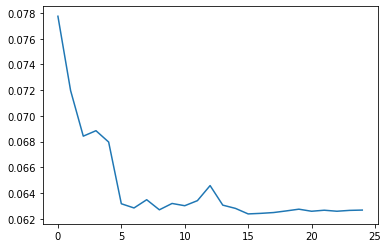

In [36]:
ver = 72
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

[0.08195003 0.06692202 0.0669104  0.06752611 0.06747011 0.06349338
 0.0626976  0.06288502 0.0625446  0.0630336  0.06283608 0.06253493
 0.06272242 0.06274802 0.06280114 0.06248627 0.06244163 0.06259594
 0.06235557 0.06252688 0.06237031 0.06266632 0.0624724  0.0625555
 0.06249723]


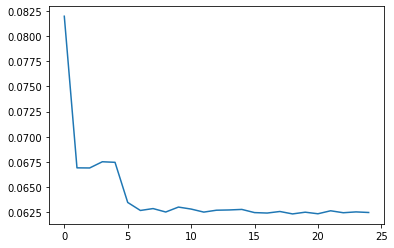

In [37]:
ver = 73
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

[0.07336126 0.06791653 0.06672474 0.06621773 0.06522342 0.06269679
 0.06271483 0.06261532 0.06283813 0.06239797 0.06266095 0.06256483
 0.06280528 0.0622756  0.062841   0.0622916  0.06234851 0.06230284
 0.06239877 0.06240432 0.06237384 0.06242769 0.06245325 0.06240852
 0.06238066]


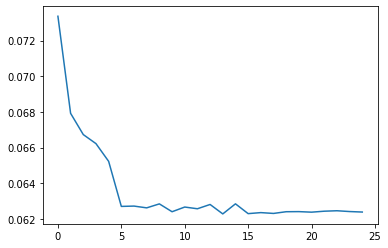

In [36]:
ver = 74
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

[0.08759543 0.07350885 0.07103133 0.06781943 0.08776392 0.06386395
 0.06370772 0.06874262 0.06357561 0.06322936 0.06313038 0.06307746
 0.06421412 0.06311881 0.06331547 0.06188674 0.06199789 0.06180143
 0.06188602 0.06173918 0.06189277 0.06183202 0.06190042 0.06189958
 0.06188536]


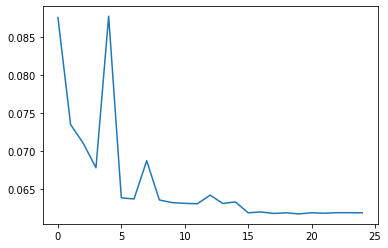

In [37]:
ver = 75
res = (pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(1,ver)).val_loss.values +
       pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(2,ver)).val_loss.values) / 3

# 5x1e-3, 10x2e-4, 7x2e-5, 3x5e-6
print(res)

plt.plot(res)

In [53]:
predictions.shape

(6494, 60, 6)

In [54]:
predictions.mean((0,1))

array([0.09723885, 0.01910229, 0.04589083, 0.0379027 , 0.04809955,
       0.05781248], dtype=float32)

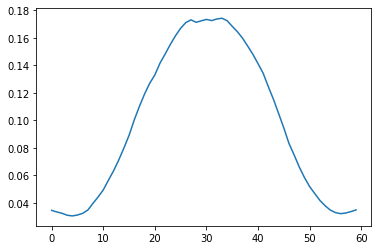

In [55]:
plt.plot(predictions.mean(0)[:,0])

# OOF

In [32]:
def oof_one(num_iter=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'iters starting now:', num_iter)
    
    setSeeds(SEED + cur_epoch)
    
    val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset valid:', len(val_ds), 'loader valid:', len(loader_val))
    
    #model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
    
    loc_data = val_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    preds = []
    
    for i in range(num_iter):
        
        val_ds.setFeats(-1)

        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)

        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))

        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            assert (offsets[k] + cnt) <= 60
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        preds.append(val_results)

        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k], eps=1e-7, labels=[0,1])\
               for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, iter {}, fold {}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}'
              .format(VERSION, i, fold, ll, cor, auc))
    
    print('total running time', time.time() - st0)
    
    return np.stack(preds)

In [140]:
stg = time.time()
for fold in range(0,1):
    predictions = oof_one(num_iter=32, bs=bs, fold=fold)
    pickle.dump(predictions, open(PATH_WORK/'oof_{}_f{}_v{}'.format(dataset_name, fold, VERSION),'wb'))
print('total time', time.time() - stg)

completed epochs: 25 iters starting now: 32
adding dummy serieses 168
DataSet 3 valid size 6656 fold 0
dataset valid: 6656 loader valid: 208
loading model model.b25.f0.v74
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.954 time per batch: 0.989
Batch 8 device: xla:1 time passed: 5.591 time per batch: 0.699
Batch 12 device: xla:1 time passed: 7.594 time per batch: 0.633
Batch 16 device: xla:1 time passed: 9.724 time per batch: 0.608
Batch 20 device: xla:1 time passed: 11.770 time per batch: 0.589
Batch 24 device: xla:1 time passed: 13.791 time per batch: 0.575
ver 74, iter 0, fold 0, val ll: 0.0636, cor: 0.8424, auc: 0.9881
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.668 time per batch: 0.917
Batch 8 device: xla:1 time passed: 5.364 time per batch: 0.670
Batch 12 device: xla:1 time passed: 7.370 time per batch: 0.614
Batch 16 device: xla:1 time passed: 9.304 time per batch: 0.581
Batch 20 device: xla:1 time passed: 11.352 time per batch: 0.568
Batch 24

Batch 4 device: xla:1 time passed: 3.857 time per batch: 0.964
Batch 8 device: xla:1 time passed: 5.469 time per batch: 0.684
Batch 12 device: xla:1 time passed: 7.485 time per batch: 0.624
Batch 16 device: xla:1 time passed: 9.437 time per batch: 0.590
Batch 20 device: xla:1 time passed: 11.411 time per batch: 0.571
Batch 24 device: xla:1 time passed: 13.322 time per batch: 0.555
ver 74, iter 17, fold 0, val ll: 0.0635, cor: 0.8429, auc: 0.9881
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.825 time per batch: 0.956
Batch 8 device: xla:1 time passed: 5.354 time per batch: 0.669
Batch 12 device: xla:1 time passed: 7.261 time per batch: 0.605
Batch 16 device: xla:1 time passed: 9.245 time per batch: 0.578
Batch 20 device: xla:1 time passed: 11.226 time per batch: 0.561
Batch 24 device: xla:1 time passed: 13.129 time per batch: 0.547
ver 74, iter 18, fold 0, val ll: 0.0636, cor: 0.8428, auc: 0.9881
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 3.616 time pe

In [ ]:
# correlation between models
# scores per slice
# what is the best way to agg oof, model\run levels
# best aggregation theoretically
# distribution of oof preds
# score - what uniform p will get
# 0.5 + np.sign(x-0.5) *2*(x-0.5)**2 - makes it less aggressive, is it a good transform above mean?
# does scaling help for single runs, or is it aggregation artifact.

# s101 problem.
    # maybe 8 and 32 behave differently

## Selecting runs aggregation

In [131]:
afuncs_names = np.array(['mean','gmean','q50','q25','q75','psig'])

def scalePreds(x, power = 2, center=0.5):
    res = x.copy()
    res[x > center] = center + (1 - center) * ((res[x > center] - center)/(1 - center))**power
    res[x < center] = center - center * ((center - res[x < center])/center)**power
    return res

def applyAggFunc(probs, func_name, axis=1, norm_axis=None):
    
    st = time.time()
    
    if func_name == 'mean':
        res = probs.mean(axis)
    elif func_name == 'max':
        res = probs.max(axis)
    elif func_name == 'min':
        res = probs.min(axis)
    elif func_name == 'gmean':
        res = np.exp(np.log(probs).mean(axis))
    elif func_name == 'q50':
        res = np.quantile(probs,q=0.5,axis=axis)
    elif func_name == 'q25':
        res = np.quantile(probs,q=0.25,axis=axis)
    elif func_name == 'q75':
        res = np.quantile(probs,q=0.75,axis=axis)
    elif func_name == 'psig':
        mask_zero = (probs >= 1).sum(axis) > 0
        res = 1 / (1 + np.exp(-(np.log(probs/(1-probs), where=(probs < 1)).mean(axis))))
        res[mask_zero] = 0
    else:
        assert True
    
    res = np.clip(res, 1e-15, 1-1e-15)
    
    #print('applying time', func_name, time.time()-st)
    return res

def getPredsOOF():
    preds_all = np.zeros((4,32,len(ids_df),6))

    for fold in range(3):
        preds = np.stack([pickle.load(open(PATH_WORK/'oof_{}_f{}_v{}'.format(name, fold, ver),'rb')) \
            for name, ver in zip(['Densenet161','Densenet169','Densenet201','se_resnext101_32x4d'], [72,73,74,78])])

        preds = np.clip(preds, 1e-15, 1-1e-15)

        preds_all[:,:,ids_df.fold == fold,:] = preds
    
    return preds_all

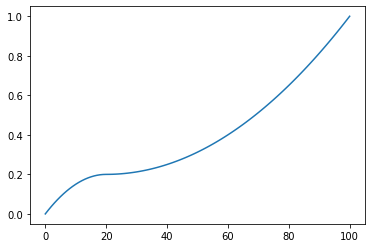

In [38]:
x = np.arange(101)/100
plt.plot(scalePreds(x, center=0.2))

In [39]:
np.set_printoptions(precision=5)

for fold in range(3):
    print('fold', fold)
    data_fold = ids_df.loc[ids_df.fold == fold]

    preds = np.stack([pickle.load(open(PATH_WORK/'oof_{}_f{}_v{}'.format(name, fold, ver),'rb')) \
        for name, ver in zip(['Densenet161','Densenet169','Densenet201','se_resnext101_32x4d'], [72,73,74,75])])

    assert len(data_fold) == preds.shape[2]
    
    preds = np.clip(preds, 1e-15, 1-1e-15)
    for afunc in afuncs_names:
        apreds = applyAggFunc(preds, afunc)
        res = ((- data_fold[all_ich].values * np.log(apreds) - (1 - data_fold[all_ich].values) * np.log(1 - apreds))\
            * class_weights).mean((1,2))
        roc = [roc_auc_score(data_fold[all_ich].values.reshape(-1), apreds[i].reshape(-1)) for i in range(4)]
        print('{:7s} {} {}'.format(afunc,res,np.array(roc)))

fold 0
mean    [0.06294 0.06291 0.06293 0.06228] [0.98806 0.98828 0.98838 0.98869]
gmean   [0.06309 0.06305 0.06306 0.06245] [0.98805 0.98825 0.98836 0.98868]
q50     [0.0632  0.06315 0.06314 0.06255] [0.98801 0.98823 0.98834 0.98864]
q25     [0.06393 0.06386 0.06384 0.0634 ] [0.98792 0.98811 0.98826 0.98855]
q75     [0.06324 0.06315 0.06306 0.06275] [0.98805 0.98826 0.98836 0.98866]
psig    [0.0631  0.06307 0.06306 0.06246] [0.98805 0.98825 0.98837 0.98868]
fold 1
mean    [0.06235 0.06219 0.06211 0.06094] [0.98843 0.98824 0.98828 0.98871]
gmean   [0.06244 0.06235 0.06223 0.0612 ] [0.98842 0.98821 0.98825 0.98863]
q50     [0.06261 0.06244 0.06233 0.06129] [0.98839 0.98818 0.98822 0.9886 ]
q25     [0.06299 0.0633  0.06295 0.06228] [0.98831 0.98806 0.9881  0.98839]
q75     [0.06314 0.06228 0.06234 0.06133] [0.98839 0.98824 0.98828 0.98873]
psig    [0.06253 0.06235 0.06233 0.06119] [0.98841 0.98821 0.98823 0.98864]
fold 2
mean    [0.05973 0.06009 0.05988 0.05889] [0.98945 0.98935 0.9896  

In [147]:
preds_all = getPredsOOF()

In [40]:
((- ids_df[all_ich].values * np.log(preds_all) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.06268, 0.06259, 0.06242, 0.06195])

In [41]:
((- ids_df[all_ich].values * np.log(preds_all.mean(1)) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all.mean(1),1e-15,1-1e-15)))
 * class_weights).mean((1,2))

array([0.06167, 0.06173, 0.06164, 0.0607 ])

In [42]:
runs_afunc = 'mean'
preds2 = applyAggFunc(preds_all, runs_afunc)

## Selecting models aggregation

In [43]:
for afunc in afuncs_names:
    #print(afunc)
    apreds = applyAggFunc(preds2, afunc, axis=0)
    res = ((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
        * class_weights).mean()
    
    if True:
        best_score = res
        best_k = 0
        for k in range(1,50):
            apreds2 = scalePreds(apreds, 1.0 + 0.01 * k)
            apreds2 = np.clip(apreds2, 1e-15, 1-1e-15)

            res2 = ((- ids_df[all_ich].values * np.log(apreds2) - (1 - ids_df[all_ich].values) * np.log(1 - apreds2))\
                    * class_weights).mean()

            if res2 > best_score: break
            best_score = res2
            best_k = k

        print('{:7s} {:5f}   {:2f} {:5f}'.format(afunc,res,1+0.01*best_k,best_score))
    else:
        print('{:7s} {:5f}'.format(afunc,res))

mean    0.059038   1.130000 0.058948
gmean   0.059353   1.230000 0.059091
q50     0.059475   1.220000 0.059233
q25     0.060483   1.390000 0.059857
q75     0.059765   1.090000 0.059715
psig    0.059371   1.250000 0.059079


In [44]:
apreds = (preds2*np.array([0.25,0.25,0.25,0.25])[:,None,None]).sum(0)
((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
        * class_weights).mean()

0.059038001710494545

In [45]:
apreds = (preds2*np.array([0.2,0.2,0.2,0.4])[:,None,None]).sum(0)
((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
        * class_weights).mean()

0.058951267412781026

In [46]:
models_afunc = 'mean'

## Scaling

In [47]:
preds_all.shape

(4, 32, 674252, 6)

In [48]:
res = ((- ids_df[all_ich].values * np.log(preds_all) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean()

In [49]:
((- ids_df[all_ich].values * np.log(preds_all) 
  - (1 - ids_df[all_ich].values) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.06268, 0.06259, 0.06242, 0.06195])

In [60]:
if False:
    best_score = res
    best_k = 0
    for k in range(1,50):
        apreds = scalePreds(preds_all, 1.0 + 0.01 * k)
        apreds = np.clip(apreds, 1e-15, 1-1e-15)

        res2 = ((- ids_df[all_ich].values * np.log(apreds) - (1 - ids_df[all_ich].values) * np.log(1 - apreds))\
                * class_weights).mean()

        if res2 > best_score: break
        best_score = res2
        best_k = k

    print('{{:5f}   {:2f} {:5f}'.format(res,1+0.01*best_k,best_score))

## Models behavior per groups

In [51]:
for col in cols_le:
    for i in ids_df[col].unique():
        res = ((- ids_df[all_ich].values * np.log(preds_all.mean(1)) - (1 - ids_df[all_ich].values) \
                * np.log(1 - preds_all.mean(1))) * class_weights)[:,(ids_df[col] == i)].mean((1,2))
        sz = (ids_df[col] == i).sum()
        sz_test = (test_md[col] == i).sum()
        print('{:20s} {:2d} {:6d} {:6d} {}'.format(col,i,sz,sz_test,res))

WindowCenter_1_le     0 248151   2157 [0.03698 0.03666 0.03689 0.03648]
WindowCenter_1_le     2  10377     34 [0.11658 0.11432 0.11603 0.11328]
WindowCenter_1_le     3 341674  75369 [0.0641  0.06452 0.06427 0.06312]
WindowCenter_1_le     1  70894    985 [0.12671 0.12636 0.12624 0.12486]
WindowCenter_1_le     4   3156      0 [0.09926 0.10629 0.0935  0.08954]
BitType_le            1 323550   3088 [0.05721 0.05696 0.05691 0.05637]
BitType_le            0 338723  75369 [0.06349 0.06391 0.06364 0.06248]
BitType_le            2   2252     60 [0.12917 0.12549 0.13399 0.12131]
BitType_le            4   6776     28 [0.13029 0.12779 0.13098 0.12574]
BitType_le            3   2951      0 [0.13416 0.13498 0.13628 0.13569]
WindowCenter_0_le     1 248151   2157 [0.03698 0.03666 0.03689 0.03648]
WindowCenter_0_le     4  10343     34 [0.11678 0.11448 0.11617 0.11338]
WindowCenter_0_le     2 151196   2148 [0.12147 0.12143 0.12132 0.11946]
WindowCenter_0_le     0 213404  69272 [0.03542 0.03602 0.03577 0

## Standard deviation analysis

In [52]:
stds = preds_all.std(1)

In [53]:
stds.mean((1))

array([[0.00728, 0.00084, 0.00367, 0.00243, 0.0047 , 0.00482],
       [0.00671, 0.0008 , 0.00339, 0.0022 , 0.00429, 0.00418],
       [0.00636, 0.00079, 0.00317, 0.00211, 0.00393, 0.00426],
       [0.00826, 0.00081, 0.00421, 0.00284, 0.00516, 0.00509]])

In [54]:
stds.shape

(4, 674252, 6)

In [55]:
for i in range(6):
    idx = stds[0,:,i].argmax()
    print(preds_all[0,:,idx,i])

[0.8527  0.05913 0.05106 0.08638 0.84558 0.05423 0.07018 0.84259 0.05583
 0.8708  0.73379 0.05164 0.09345 0.84263 0.05725 0.06355 0.77368 0.74033
 0.06283 0.08262 0.84567 0.75806 0.06629 0.78966 0.0677  0.09178 0.75401
 0.09415 0.05611 0.05517 0.7346  0.06335]
[0.17928 0.70484 0.13346 0.3709  0.11267 0.75836 0.78877 0.83044 0.19143
 0.64169 0.32809 0.56139 0.43426 0.04446 0.71558 0.44262 0.80938 0.4324
 0.33778 0.10167 0.67786 0.06138 0.69132 0.60487 0.09624 0.18512 0.09897
 0.77576 0.22602 0.06148 0.69764 0.47782]
[0.74571 0.01364 0.01121 0.01677 0.75372 0.01375 0.01258 0.76661 0.01464
 0.79489 0.64169 0.01377 0.01875 0.75287 0.01151 0.01513 0.67222 0.63221
 0.01502 0.01762 0.75902 0.65048 0.01416 0.66272 0.01473 0.01909 0.62214
 0.01877 0.0129  0.01269 0.6123  0.01739]
[0.17227 0.13973 0.16937 0.83901 0.14405 0.85284 0.13655 0.84228 0.1366
 0.86727 0.14551 0.84461 0.12285 0.1583  0.17251 0.8441  0.15338 0.8711
 0.14259 0.13445 0.84192 0.83398 0.85628 0.1391  0.15021 0.16618 0.8538
 0

In [56]:
for i in range(6):
    idx = stds[3,:,i].argmax()
    print(preds_all[3,:,idx,i])

[0.98124 0.97982 0.18154 0.16633 0.14569 0.19571 0.99596 0.99338 0.97808
 0.97289 0.9829  0.15496 0.2188  0.98177 0.99533 0.99498 0.96824 0.99605
 0.98322 0.99441 0.16313 0.99583 0.98061 0.96437 0.15794 0.15645 0.99488
 0.15732 0.99349 0.97802 0.97599 0.9767 ]
[0.55692 0.10884 0.20442 0.59746 0.09779 0.0987  0.10347 0.37919 0.17011
 0.61534 0.44436 0.22315 0.51828 0.39134 0.08508 0.27187 0.1056  0.56182
 0.33682 0.1808  0.05546 0.57841 0.66401 0.43134 0.08713 0.14838 0.57806
 0.1089  0.11133 0.15189 0.37018 0.48509]
[0.98467 0.98967 0.98078 0.99126 0.98817 0.10488 0.98166 0.07737 0.9917
 0.09423 0.98358 0.98718 0.0983  0.98882 0.08635 0.9884  0.98168 0.11393
 0.98395 0.98987 0.98443 0.98585 0.98444 0.98965 0.07219 0.99001 0.98623
 0.98711 0.98511 0.13202 0.98884 0.98827]
[0.083   0.9279  0.40258 0.30925 0.14412 0.20776 0.94867 0.31848 0.1495
 0.93255 0.92421 0.92861 0.92252 0.17523 0.94506 0.9094  0.93786 0.95375
 0.91946 0.95732 0.2661  0.94855 0.8828  0.27029 0.27056 0.95248 0.15744


In [57]:
((- preds_all.mean(1, keepdims=True) * np.log(preds_all) 
  - (1 - preds_all.mean(1, keepdims=True)) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2))

array([[0.14491, 0.00945, 0.03508, 0.02361, 0.05398, 0.06132],
       [0.14669, 0.01034, 0.03552, 0.02403, 0.05463, 0.06025],
       [0.14752, 0.00944, 0.03492, 0.02384, 0.05311, 0.06174],
       [0.14552, 0.01318, 0.03636, 0.02443, 0.05468, 0.06079]])

In [58]:
((- preds_all.mean(1, keepdims=True) * np.log(preds_all) 
  - (1 - preds_all.mean(1, keepdims=True)) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.05472, 0.05524, 0.05509, 0.05582])

In [59]:
((- preds_all.mean((1,2), keepdims=True) * np.log(preds_all) 
  - (1 - preds_all.mean((1,2), keepdims=True)) * np.log(np.clip(1 - preds_all,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([0.6043 , 0.60165, 0.59441, 0.6038 ])

# Inference

In [106]:
def inference_one(bs = 100, add_seed = 0, fold = 0, anum = 0):
    st = time.time()

    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    #model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch + anum + 100*fold)

    tst_ds = RSNA_DataSet(test_md, mode='test', bs=bs, fold=fold)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))
    
    tst_ds.setFeats(-1)

    loc_data = tst_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()

    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    val_results = []
    for k, series in enumerate(np.sort(loc_data.index.unique())):
        cnt = series_counts[series]
        assert (offsets[k] + cnt) <= 60
        val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

    val_results = np.concatenate(val_results)
    assert np.isnan(val_results).sum() == 0
    val_results = val_results[loc_data.my_order]
    assert len(val_results) == len(loc_data)

    print('test processing time:', time.time() - st)
    
    return val_results

In [110]:
preds = []
stg = time.time()
for fold in range(3):
    preds2 = []
    for anum in range(32):
        predictions = inference_one(fold = fold, anum = anum, bs=bs)
        preds2.append(predictions)
    preds.append(np.stack(preds2))
preds = np.stack(preds)
print('total time', time.time() - stg)

pickle.dump(preds, open(PATH_WORK/'preds_{}_v{}'.format(dataset_name, VERSION),'wb'))

completed epochs: 25
loading model model.b25.f0.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 0
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 14.281991481781006
completed epochs: 25
loading model model.b25.f0.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 0
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 6.552208185195923
completed epochs: 25
loading model model.b25.f0.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 0
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 6.54830002784729
completed epochs: 25
loading model model.b25.f0.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 0
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.153745889663696
completed epochs: 25
loading model model.b25.f0.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 0
dataset test: 2304 loader test: 72
setFeats, augmen

test processing time: 6.466729640960693
completed epochs: 25
loading model model.b25.f1.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 1
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 6.4442925453186035
completed epochs: 25
loading model model.b25.f1.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 1
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.894742965698242
completed epochs: 25
loading model model.b25.f1.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 1
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.62102746963501
completed epochs: 25
loading model model.b25.f1.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 1
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.6126933097839355
completed epochs: 25
loading model model.b25.f1.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 1
dataset te

test processing time: 7.5347044467926025
completed epochs: 25
loading model model.b25.f2.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 2
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.699728965759277
completed epochs: 25
loading model model.b25.f2.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 2
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.624472141265869
completed epochs: 25
loading model model.b25.f2.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 2
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.710848093032837
completed epochs: 25
loading model model.b25.f2.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 2
dataset test: 2304 loader test: 72
setFeats, augmentation -1
test processing time: 7.572486639022827
completed epochs: 25
loading model model.b25.f2.v73
adding dummy serieses 90
DataSet 4 test size 2304 fold 2
dataset te

In [70]:
preds.shape

(3, 32, 78545, 6)

In [69]:
preds.mean((0,1,2))

array([0.13040587, 0.00469896, 0.04276207, 0.03016115, 0.04547987,
       0.05334486], dtype=float32)

# Files transfer

In [89]:
!gsutil cp /home/zahar_chikishev/running/oof* gs://rsna-hemorrhage/results

Copying file:///home/zahar_chikishev/running/oof_Densenet161_f0_v72 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///home/zahar_chikishev/running/oof_Densenet161_f1_v72 [Content-Type=application/octet-stream]...
Copying file:///home/zahar_chikishev/running/oof_Densenet161_f2_v72 [Content-Type=applicatio

In [150]:
!gsutil cp /home/zahar_chikishev/running/preds* gs://rsna-hemorrhage/results

Copying file:///home/zahar_chikishev/running/preds_Densenet161_v72 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file:///home/zahar_chikishev/running/preds_Densenet169_v73 [Content-Type=application/octet-stream]...
Copying file:///home/zahar_chikishev/running/preds_Densenet201_v74 [Content-Type=application/o

In [ ]:
!gsutil gs://rsna-hemorrhage/results/* .

In [19]:
!rm /home/zahar_chikishev/running/*v53

In [18]:
!ls /home/zahar_chikishev/running/*v53

/home/zahar_chikishev/running/preds_se_resnext101_32x4d_v53
/home/zahar_chikishev/running/stats.f0.v53
/home/zahar_chikishev/running/stats.f1.v53
/home/zahar_chikishev/running/stats.f2.v53


In [20]:
!ls /home/zahar_chikishev/running/oof*

/home/zahar_chikishev/running/oof_Densenet161_f0_v72
/home/zahar_chikishev/running/oof_Densenet161_f1_v72
/home/zahar_chikishev/running/oof_Densenet161_f2_v72
/home/zahar_chikishev/running/oof_Densenet169_f0_v73
/home/zahar_chikishev/running/oof_Densenet169_f1_v73
/home/zahar_chikishev/running/oof_Densenet169_f2_v73
/home/zahar_chikishev/running/oof_Densenet201_f0_v74
/home/zahar_chikishev/running/oof_Densenet201_f1_v74
/home/zahar_chikishev/running/oof_Densenet201_f2_v74
/home/zahar_chikishev/running/oof_se_resnext101_32x4d_f0_v75
/home/zahar_chikishev/running/oof_se_resnext101_32x4d_f1_v75
/home/zahar_chikishev/running/oof_se_resnext101_32x4d_f2_v75


In [21]:
!ls /home/zahar_chikishev/running/preds*

/home/zahar_chikishev/running/preds_Densenet161_v72
/home/zahar_chikishev/running/preds_Densenet169_v73
/home/zahar_chikishev/running/preds_Densenet201_v74
/home/zahar_chikishev/running/preds_se_resnext101_32x4d_v75


# Ensembling

In [35]:
preds_all = getPredsOOF()

In [61]:
preds_all.shape

(4, 32, 674252, 6)

In [148]:
def getSecondStepX(ids_df, preds_all, TH, powerLow=0.7, powerHigh=1.5, fold=0, target=0, ds_idx=0, mode='train'):
    
    X = np.stack([pickle.load(open(PATH_WORK/'ensemble'/'first.d{}.f{}.t{}.v{}'
                                   .format(ds_idx,fold,target,VERSION),'rb')) for ds_idx in range(4)])
    
    if mode == 'train':
        X = X[:,ids_df.fold != fold]
        y = ids_df.loc[ids_df.fold != fold, all_ich[target]].values
    elif mode == 'valid':
        X = X[:,ids_df.fold == fold]
        y = ids_df.loc[ids_df.fold == fold, all_ich[target]].values
    else:
        X = X
        y = None
    
    ll = None
    auc = None
    if y is not None:
        ll = log_loss(y, X.mean(0), eps=1e-7, labels=[0,1])
        auc = roc_auc_score(y, X.mean(0))
    
    return X, y, ll, auc


def getFirstStepX(ids_df, preds_all, TH, powerLow=0.7, powerHigh=1.5, fold=0, target=0, ds_idx=0, mode='train'):
    
    X0 = preds_all[ds_idx]
    X0 = X0.mean(0)
    
    if mode == 'train':
        X0 = X0[ids_df.fold != fold]
        y = ids_df.loc[ids_df.fold != fold, all_ich[target]].values
    elif mode == 'valid':
        X0 = X0[ids_df.fold == fold]
        y = ids_df.loc[ids_df.fold == fold, all_ich[target]].values
    else:
        X0 = X0
        y = None
    
    X0 = X0[:,target]
    
    ll = None
    auc = None
    if y is not None:
        ll = log_loss(y, X0, eps=1e-7, labels=[0,1])
        auc = roc_auc_score(y, X0)
    
    X = np.stack([np.where(X0 > TH,X0,np.zeros(X0.shape)),
                  np.where(X0 > TH,scalePreds(X0,power=powerLow,center=TH),np.zeros(X0.shape)),
                  np.where(X0 > TH,scalePreds(X0,power=powerHigh,center=TH),np.zeros(X0.shape)),
                  np.where(X0 <= TH,X0,np.zeros(X0.shape)),
                  np.where(X0 <= TH,scalePreds(X0,power=powerLow,center=TH),np.zeros(X0.shape)),
                  np.where(X0 <= TH,scalePreds(X0,power=powerHigh,center=TH),np.zeros(X0.shape)),
                  ])
    
    return X, y, ll, auc


def train_ensemble(ids_df, preds_all, fold = 0, target = 0, ds_idx = 0, first_step = True):
    
    if first_step:
        print('starting model',ds_idx,'fold',fold,'target',target)
    else:
        print('starting fold',fold,'target',target)
    
    st = time.time()
    intercept = False
    
    limit_low = 1e-15
    limit_high = 1 - 1e-4
    
    prior = ids_df.loc[ids_df.fold != fold, all_ich[target]].mean()
    powerLow = 0.7
    powerHigh = 1.5
    
    def my_objective(x,preds,vals):
        preds_sum = np.clip((preds * x[:,None]).sum(0), limit_low, limit_high)
        res = (- vals * np.log(preds_sum) - (1 - vals) * np.log(1 - preds_sum)).mean()
        #print('x   ',x, x.sum())
        print('obj ',res)
        return res

    def my_grad(x,preds,vals):
        preds_sum = np.clip((preds * x[:,None]).sum(0), limit_low, limit_high)
        res = (- vals * preds / preds_sum + (1 - vals) * preds / (1 - preds_sum)).mean(1)
        #print('grad',res)
        return res

    def my_hess(x,preds,vals):
        preds_sum = np.clip((preds * x[:,None]).sum(0), limit_low, limit_high)
        res = (preds * np.expand_dims(preds, axis=1) * (vals / preds_sum**2 + (1 - vals) / (1 - preds_sum)**2)).mean(2)
        return res
    
    if first_step: data_func = getFirstStepX
    else: data_func = getSecondStepX
    
    X,y,ll_train,auc_train =  data_func(ids_df, preds_all, TH=prior, powerLow=powerLow, powerHigh=powerHigh, 
                                        fold=fold, target=target, ds_idx=ds_idx)
    
    bnds_low = np.zeros(X.shape[0])
    bnds_high = np.ones(X.shape[0])
    
    if first_step:
        initial_sol = np.array([1,0,0,1,0,0])
        splitted = True
    else:
        initial_sol = np.ones(4)/4
        splitted = False
    
    if intercept:
        X = np.concatenate([X,np.ones((1,X.shape[1]))], axis=0)
        bnds_low = np.concatenate([bnds_low, -0.1*np.ones(1)])
        bnds_high = np.concatenate([bnds_high, 0.1*np.ones(1)])
        initial_sol = np.concatenate([initial_sol, np.zeros(1)])

    bnds = sp.optimize.Bounds(bnds_low, bnds_high)
    cons = sp.optimize.LinearConstraint(np.ones((1,X.shape[0])), 0.95 + splitted, 1.01 + splitted)
    
    model = sp.optimize.minimize(my_objective, initial_sol, jac=my_grad, hess=my_hess, args=(X, y),
                                 bounds=bnds, method='trust-constr', constraints=cons,
                                 options={'gtol': 1e-11, 'initial_tr_radius': 0.1, 'initial_barrier_parameter': 0.01})
    model.prior = prior
    model.powerLow = powerLow
    model.powerHigh = powerHigh
    
    pickle.dump(model, open(PATH_WORK/'ensemble'/'model.d{}.f{}.t{}.v{}'
                            .format(ds_idx,fold,target,VERSION),'wb'))

    train_preds = (X*np.expand_dims(model.x, axis=1)).sum(0)
    ll_train2 = log_loss(y, train_preds, eps=1e-7, labels=[0,1])
    auc_train2 = roc_auc_score(y, train_preds)
    
    X,y,ll_val,auc_val =  data_func(ids_df, preds_all, TH=prior, powerLow=powerLow, powerHigh=powerHigh, 
                                    fold=fold, target=target, ds_idx=ds_idx, mode='valid')
    
    val_preds = (X*np.expand_dims(model.x, axis=1)).sum(0)
    
    if first_step:
        total_preds = np.zeros(len(ids_df))
        total_preds[ids_df.fold == fold] = val_preds
        total_preds[ids_df.fold != fold] = train_preds
        pickle.dump(total_preds, open(PATH_WORK/'ensemble'/'first.d{}.f{}.t{}.v{}'
                                      .format(ds_idx,fold,target,VERSION),'wb'))
    
    ll_val2 = log_loss(y, val_preds, eps=1e-7, labels=[0,1])
    auc_val2 = roc_auc_score(y, val_preds)
    
    print('v{} d{} f{} t{}: original ll {:.4f} auc {:.4f}, ensemble ll {:.4f} auc {:.4f}'
          .format(VERSION,ds_idx,fold,target,ll_val,auc_val,ll_val2,auc_val2))
    
    run_time = time.time() - st
    print('running time', run_time)
    
    stats = pd.DataFrame([[VERSION,ds_idx,fold,target,
                           ll_train,auc_train,ll_train2,auc_train2,
                           ll_val,auc_val,ll_val2,auc_val2,run_time]], 
                           columns = 
                            ['version','ds_idx','fold','target',
                             'train_loss','train_auc','train_loss_ens','train_auc_ens', 
                             'valid_loss','valid_auc','valid_loss_ens','valid_auc_ens',
                             'run_time'
                             ])

    stats_filename = PATH_WORK/'ensemble'/'stats.v{}'.format(VERSION)
    if stats_filename.is_file():
        stats = pd.concat([pd.read_csv(stats_filename), stats], sort=False)
    stats.to_csv(stats_filename, index=False)

#model.cols = Xt.columns
#predictions[data_filt['fold'] == i] = (Xv*model.x).sum(1)

In [64]:
stg = time.time()
for fold in range(3):
    for ds_idx in range(4):
        for target in range(6):
            train_ensemble(ids_df, preds_all, fold=fold, target=target, ds_idx=ds_idx, first_step=True)
print('total running time', time.time() - stg)

starting model 0 fold 0 target 0
obj  0.09907104708842213
obj  0.09892819004361318
obj  0.09861301496709195
obj  0.09905568100165757
obj  0.09846707763627867
obj  0.09863771159124068
obj  0.09855815146715811
obj  0.09858343735029174
obj  0.09826212464588814
obj  0.0981145749996947
obj  0.09806504219266403
obj  0.09804757463273832
obj  0.0980428363711221
obj  0.0980427754767593
obj  0.09804148663073323
obj  0.09804139900592725
obj  0.09804137002508502
obj  0.09804136352515554
obj  0.09804136285137507
obj  0.098041362851374
v76 d0 f0 t0: original ll 0.1001 auc 0.9860, ensemble ll 0.0993 auc 0.9860
running time 4.16136908531189
starting model 0 fold 0 target 1
obj  0.017152870190242524
obj  0.017111446799319186
obj  0.016994172896724617
obj  0.01676896466781925
obj  0.016492940281716054
obj  0.01615700648255296
obj  0.016317749643019304
obj  0.016118607550579752
obj  0.015917744415769364
obj  0.015588037798158347
obj  0.01547997799313031
obj  0.0154359186482124
obj  0.015432554524827717
o

obj  0.014974523824709722
obj  0.014964986526830953
obj  0.014961202311578655
obj  0.014960927019246834
obj  0.014960926957499511
obj  0.014960822306788715
obj  0.014960808943806999
v76 d2 f0 t1: original ll 0.0171 auc 0.9733, ensemble ll 0.0166 auc 0.9732
running time 3.949699878692627
starting model 2 fold 0 target 2
obj  0.040478811693892065
obj  0.04047626658473636
obj  0.04047305609404188
obj  0.04055498098018409
obj  0.040461540627126986
obj  0.040459339372850046
obj  0.04045852653603437
obj  0.04045902685254254
obj  0.040453543967913556
obj  0.04045353804221251
obj  0.04044323473199028
obj  0.04044322910382726
obj  0.040436742422529544
obj  0.040436071275843206
obj  0.04043554701926998
obj  0.0404355044416744
obj  0.04043546942512576
obj  0.04043546206242466
v76 d2 f0 t2: original ll 0.0447 auc 0.9916, ensemble ll 0.0446 auc 0.9916
running time 3.843823194503784
starting model 2 fold 0 target 3
obj  0.025039554684039095
obj  0.025065307545520853
obj  0.025081382629239396
obj  0.

obj  0.01699186733905832
obj  0.016856793846749783
obj  0.01681444248012427
obj  0.016799701426338624
obj  0.01679585480939872
obj  0.016794439736906246
obj  0.01679425576348235
obj  0.016794195271893048
obj  0.016794195221160498
obj  0.01679417565853585
obj  0.016794175640764696
v76 d0 f1 t1: original ll 0.0163 auc 0.9578, ensemble ll 0.0147 auc 0.9578
running time 3.513916015625
starting model 0 fold 1 target 2
obj  0.041467889095624766
obj  0.041440177701903044
obj  0.04143589013263906
obj  0.04142832528904869
obj  0.04141335547491895
obj  0.04139708690852094
obj  0.041398353470351264
obj  0.04139832823149106
obj  0.04138773725056222
obj  0.04136830071759993
obj  0.04136179151108211
obj  0.041360166063868255
obj  0.0413594528899508
obj  0.04135932619938225
obj  0.041359299812680425
obj  0.04135929578525934
v76 d0 f1 t2: original ll 0.0434 auc 0.9914, ensemble ll 0.0433 auc 0.9914
running time 3.18940806388855
starting model 0 fold 1 target 3
obj  0.025805151803121252
obj  0.02581173

obj  0.026245950097549545
obj  0.026235845592610232
obj  0.02625288558396789
obj  0.02619691013026706
obj  0.026244925361650847
obj  0.026218996731394117
obj  0.026221968133025367
obj  0.02621941124220829
obj  0.026188546254774403
obj  0.026154898526883227
obj  0.026149493653963855
obj  0.02614544433543979
obj  0.026144939230650175
obj  0.026144673035875483
obj  0.02614463365374582
obj  0.02614461875331107
obj  0.026144615714484957
obj  0.026144615216902665
v76 d2 f1 t3: original ll 0.0245 auc 0.9967, ensemble ll 0.0244 auc 0.9967
running time 3.3636105060577393
starting model 2 fold 1 target 4
obj  0.06601177707041317
obj  0.06598554048625979
obj  0.06590212877764616
obj  0.06612569905403237
obj  0.06588431081422962
obj  0.06589425486582222
obj  0.0658948063421742
obj  0.06589933283114953
obj  0.06587656302150743
obj  0.06583949982008733
obj  0.06583949604678009
obj  0.06583393785880999
obj  0.06583200132690405
obj  0.06583198161636768
obj  0.06583187523862943
obj  0.06583185318171472

obj  0.06625772068030814
obj  0.06625771679220359
obj  0.0662577075541715
v76 d0 f2 t4: original ll 0.0652 auc 0.9814, ensemble ll 0.0651 auc 0.9814
running time 3.709974527359009
starting model 0 fold 2 target 5
obj  0.08379866847083157
obj  0.08366255154896819
obj  0.08350034860125438
obj  0.08376899484299849
obj  0.08342756669387166
obj  0.08346776352757247
obj  0.0834660967831078
obj  0.08346183142770656
obj  0.08332464808475593
obj  0.08322415000867651
obj  0.08318716008462161
obj  0.08317903798761841
obj  0.08317710189557921
obj  0.08317643034569577
obj  0.08317642967133414
obj  0.08317626598593726
obj  0.08317624093061678
obj  0.08317623716305397
obj  0.08317623618473749
obj  0.08317623594336271
v76 d0 f2 t5: original ll 0.0781 auc 0.9801, ensemble ll 0.0775 auc 0.9801
running time 4.181798934936523
starting model 1 fold 2 target 0
obj  0.10121223989504909
obj  0.10110376861534237
obj  0.1008296449749687
obj  0.10152296348421277
obj  0.10077106481615779
obj  0.10101335550694499


obj  0.09909429143309252
obj  0.0989183864199721
obj  0.09884466134540602
obj  0.09881663749704153
obj  0.09881594620466352
obj  0.09880903896241731
obj  0.09880888856736075
obj  0.09880887343220295
obj  0.09880785308841643
obj  0.09880785274329085
obj  0.09880768268437111
obj  0.09880763542584693
obj  0.0988076251704405
obj  0.09880762283649376
obj  0.0988076223265247
v76 d3 f2 t0: original ll 0.0958 auc 0.9878, ensemble ll 0.0950 auc 0.9878
running time 4.010719060897827
starting model 3 fold 2 target 1
obj  0.015462246383702843
obj  0.01545362552021862
obj  0.015470160577136044
obj  0.015419244297045177
obj  0.015477138070137229
obj  0.01545560438242597
obj  0.015457934713095211
obj  0.015452585782768887
obj  0.015416447981949867
obj  0.01537640204223976
obj  0.015362605277079514
obj  0.01536059424270633
obj  0.015359947157378722
obj  0.015359805715102657
obj  0.015359776852778053
v76 d3 f2 t1: original ll 0.0157 auc 0.9660, ensemble ll 0.0155 auc 0.9660
running time 3.0481102466583

In [74]:
stats = pd.read_csv(PATH_WORK/'ensemble'/'stats.v{}'.format(VERSION))

agg = stats.loc[stats.ds_idx != -1].groupby('target').mean().sort_index()
print('train original ll {:.5f} ensemble ll {:.5f}'
      .format((agg.train_loss * class_weights).mean(), (agg.train_loss_ens * class_weights).mean()))
print('valid original ll {:.5f} ensemble ll {:.5f}'
      .format((agg.valid_loss * class_weights).mean(), (agg.valid_loss_ens * class_weights).mean()))

train original ll 0.06144 ensemble ll 0.06087
valid original ll 0.06144 ensemble ll 0.06098


In [67]:
stg = time.time()
for fold in range(3):
    for target in range(6):
        train_ensemble(ids_df, preds_all, fold=fold, target=target, ds_idx=-1, first_step=False)
print('total running time', time.time() - stg)

starting fold 0 target 0
obj  0.09500484923394473
obj  0.09529367923647915
obj  0.09528080618048654
obj  0.0952703356675507
obj  0.09526378433992612
obj  0.09524753240650495
obj  0.09523823521652233
obj  0.09522612351625587
obj  0.09520849534498264
obj  0.09498668021115456
obj  0.09490227498622372
obj  0.09488815133162556
obj  0.09487456085983453
obj  0.09486223115507886
obj  0.09484992470640322
obj  0.09483943418450312
obj  0.09483046262072763
obj  0.09482260925370631
obj  0.0948141659094314
obj  0.09480503930269839
obj  0.09479378258139731
obj  0.09478244445672451
obj  0.09477304107031796
obj  0.09476035047912414
obj  0.09473661902195346
obj  0.09469999931211286
obj  0.09468409347354524
obj  0.09468275515725745
obj  0.09468263201675124
obj  0.09468262851207376
obj  0.09468262790040638
obj  0.09468262789839663
obj  0.09468262789805211
v76 d-1 f0 t0: original ll 0.0963 auc 0.9871, ensemble ll 0.0962 auc 0.9871
running time 5.222867488861084
starting fold 0 target 1
obj  0.0140433130779

obj  0.038806699386862924
obj  0.03880669938665379
obj  0.03880669938665379
obj  0.038806699386549216
obj  0.038806699386549216
obj  0.03880669938649696
obj  0.03880669938649696
v76 d-1 f0 t2: original ll 0.0422 auc 0.9928, ensemble ll 0.0423 auc 0.9928
running time 13.786998271942139
starting fold 0 target 3
obj  0.023609773018361778
obj  0.023615096321507056
obj  0.0236142404333964
obj  0.023613705377956637
obj  0.02361413279909676
obj  0.02361461177603344
obj  0.023613872485157013
obj  0.023612287065513545
obj  0.023608741594337106
obj  0.023586870166904507
obj  0.023585724506943247
obj  0.02358572920078412
obj  0.023584876794310483
obj  0.023584727346692584
obj  0.02358353850558561
obj  0.023583185846083776
obj  0.023583098333935085
obj  0.02358221147818194
obj  0.023581900491732827
obj  0.02358175231295349
obj  0.02358167081656074
obj  0.02358073563913367
obj  0.023580458128405004
obj  0.023580278129068512
obj  0.02358015137972864
obj  0.023580054718356478
obj  0.02357997392635130

obj  0.0944706633312144
obj  0.09445941361275961
obj  0.09444765499743382
obj  0.09443857678229935
obj  0.09442892422493561
obj  0.09440660593114547
obj  0.09439341220827879
obj  0.09439251623210515
obj  0.09439242558687126
obj  0.09439242311549899
obj  0.09439242292293465
obj  0.094392422922531
obj  0.09439242292250352
obj  0.09439242292250324
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj  0.09439242292250323
obj

obj  0.06389547190412385
obj  0.0638954719039238
obj  0.0638954719039238
obj  0.06389547190382376
obj  0.06389547190382376
v76 d-1 f1 t4: original ll 0.0630 auc 0.9810, ensemble ll 0.0631 auc 0.9811
running time 7.777350664138794
starting fold 1 target 5
obj  0.07802895524673249
obj  0.07801669965448224
obj  0.07801198310895124
obj  0.07802182788577706
obj  0.07842034015450255
obj  0.07841540714520158
obj  0.07841181779465262
obj  0.07835464974122705
obj  0.07826078128280047
obj  0.0780778546283492
obj  0.07807341643138034
obj  0.07802355056908397
obj  0.07790756620310457
obj  0.07790594722080679
obj  0.07790594212763206
obj  0.07790590193242067
obj  0.07790590193164486
v76 d-1 f1 t5: original ll 0.0798 auc 0.9791, ensemble ll 0.0796 auc 0.9792
running time 3.034079074859619
starting fold 2 target 0
obj  0.09660699921819424
obj  0.097152201988414
obj  0.09713518083122927
obj  0.09712166819644497
obj  0.09711293292433218
obj  0.09709233042403975
obj  0.09708016422553647
obj  0.097066510

In [75]:
stats = pd.read_csv(PATH_WORK/'ensemble'/'stats.v{}'.format(VERSION))

agg = stats.loc[stats.ds_idx == -1].groupby('target').mean().sort_index()
print('train original ll {:.5f} ensemble ll {:.5f}'
      .format((agg.train_loss * class_weights).mean(), (agg.train_loss_ens * class_weights).mean()))
print('valid original ll {:.5f} ensemble ll {:.5f}'
      .format((agg.valid_loss * class_weights).mean(), (agg.valid_loss_ens * class_weights).mean()))

train original ll 0.05883 ensemble ll 0.05871
valid original ll 0.05891 ensemble ll 0.05883


In [133]:
VERSION = 76

In [146]:
preds.shape

(4, 3, 32, 78545, 6)

In [149]:
stg = time.time()
preds = np.stack([pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet161', 72),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 73),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 74),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 78),'rb'))])

test_preds_trgt = []
for target in range(6):
    
    test_preds_folds = []
    for fold in range(3):
        
        test_preds = []
        for ds_idx in range(4):
            model = pickle.load(open(PATH_WORK/'ensemble'/'model.d{}.f{}.t{}.v{}'
                                     .format(ds_idx,fold,target,VERSION),'rb'))
            X,y,ll_train,auc_train =  getFirstStepX(None, preds[:,fold], TH=model.prior, 
                                                    powerLow=model.powerLow, powerHigh=model.powerHigh, 
                                                    fold=fold, target=target, ds_idx=ds_idx, mode='test')
            test_preds.append((X*np.expand_dims(model.x, axis=1)).sum(0))
        
        X = np.stack(test_preds)
        model = pickle.load(open(PATH_WORK/'ensemble'/'model.d{}.f{}.t{}.v{}'
                                 .format(-1,fold,target,VERSION),'rb'))
        test_preds_folds.append((X*np.expand_dims(model.x, axis=1)).sum(0))
    
    X = np.stack(test_preds_folds).mean(0)
    test_preds_trgt.append(X)

predictions = np.stack(test_preds_trgt,axis=1)

print('total running time', time.time() - stg)

> <ipython-input-148-cef4c255a535>(28)getFirstStepX()
-> X0 = preds_all[ds_idx]
(Pdb) preds_all.shape
(4, 32, 78545, 6)
(Pdb) X0 = preds_all[ds_idx]
(Pdb) X0.shape
(32, 78545, 6)
(Pdb) q


BdbQuit: 

In [137]:
predictions.shape

(78545, 6)

# Submitting

In [51]:
preds = 0.5* (pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 51),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 52),'rb')))

In [53]:
preds = (pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 51),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 52),'rb')) +
         pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 53),'rb'))) / 3

In [114]:
preds = np.stack([pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet161', 72),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet169', 73),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('Densenet201', 74),'rb')),
                  pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 78),'rb'))])

In [118]:
np.set_printoptions(precision=5)

In [147]:
preds.std(2).mean((1,2))

array([[0.00797, 0.00125, 0.0039 , 0.0026 , 0.00511, 0.00504],
       [0.00727, 0.00117, 0.00363, 0.00238, 0.00469, 0.00434],
       [0.00687, 0.00118, 0.00313, 0.00217, 0.00415, 0.00443],
       [0.00905, 0.00102, 0.00443, 0.00315, 0.00575, 0.00509]],
      dtype=float32)

In [63]:
((- preds.mean((1,2), keepdims=True) * np.log(np.clip(preds,1e-15,1-1e-15)) 
  - (1 - preds.mean((1,2), keepdims=True)) * np.log(np.clip(1 - preds,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3))

array([[0.15249, 0.01507, 0.03719, 0.02508, 0.05596, 0.06206],
       [0.14765, 0.01445, 0.03652, 0.02455, 0.05567, 0.05837],
       [0.14786, 0.01586, 0.0346 , 0.02439, 0.05371, 0.06038],
       [0.1466 , 0.01732, 0.03613, 0.02529, 0.05583, 0.05959]])

In [65]:
((- preds.mean((1,2,3), keepdims=True) * np.log(np.clip(preds,1e-15,1-1e-15)) 
  - (1 - preds.mean((1,2,3), keepdims=True)) * np.log(np.clip(1 - preds,1e-15,1-1e-15)))
 * class_weights).mean((1,2,3,4))

array([0.54027, 0.54585, 0.53983, 0.54938])

In [189]:
preds = pickle.load(open(PATH_WORK/'preds_{}_v{}'.format('se_resnext101_32x4d', 75),'rb'))

In [35]:
preds.shape

(3, 32, 78545, 6)

In [194]:
predictions = np.quantile(preds,q=0.5,axis=(1)).mean(0)

In [120]:
predictions = preds.mean((0,1,2))

In [73]:
predictions = scalePreds(predictions, 1.13)

In [138]:
test_md['pred_any'] = predictions[:,0]

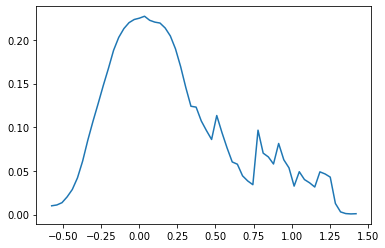

In [139]:
plt.plot(test_md[['pos_idx1','pred_any']].groupby('pos_idx1').mean())

In [89]:
predictions = np.exp(np.log(preds).mean((0,1)))

In [43]:
predictions = 1 / (1 + np.exp(-(np.log(preds/(1-preds)).mean((0,1)))))

In [73]:
predictions = preds.mean((0,1))

In [140]:
predictions.mean(0)

array([0.13103, 0.00573, 0.04287, 0.03007, 0.04574, 0.05545])

In [57]:
predictions.mean(0)

array([0.1280228 , 0.00678272, 0.04317398, 0.03195811, 0.04593468,
       0.05528003], dtype=float32)

In [141]:
id_column = np.array([a + '_' + b for a in test_md.SOPInstanceUID for b in all_ich])
sub = pd.DataFrame({'ID': id_column, 'Label': predictions.reshape(-1)})

In [142]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13102866828708357

In [58]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1281835436820984

In [77]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [78]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250275

In [143]:
sub.to_csv(PATH/'sub.csv', index=False)

In [144]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9941991502803574

In [63]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9944464662920349

In [145]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f ~/sub.csv -m "TPU, d161+d169+d201+s101, 32TTA, 3folds, ensemble"

100%|██████████████████████████████████████| 20.7M/20.7M [00:03<00:00, 6.03MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [87]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f C:/StudioProjects/Hemorrhage/sub.csv -m "TPU, d161+d169+d201+s101, 32TTA, 3folds, mean/ensemble/mean "

Traceback (most recent call last):
  File "/anaconda3/envs/torch-xla-nightly/bin/kaggle", line 10, in <module>
    sys.exit(main())
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/kaggle/cli.py", line 51, in main
    out = args.func(**command_args)
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 545, in competition_submit_cli
    competition, quiet)
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/kaggle/api/kaggle_api_extended.py", line 496, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/anaconda3/envs/torch-xla-nightly/lib/python3.6/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'C:/StudioProjects/Hemorrhage/sub.csv'
